In [1]:
import pandas as pd
import numpy as np

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()

FILENAME = "cleaned_movies.csv"
DATA_PATH = os.getenv("FILES_LOCATION")
RECOMMENDER_TYPE = "demographic"
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, DATA_PATH, "PNG", RECOMMENDER_TYPE)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, extension="png", resolution=300):  # Función para guardar las figuras que se vayan generando
    img_path = os.path.join(IMAGES_PATH, fig_id + "." + extension)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(img_path, format=extension, dpi=resolution)

In [3]:
from matplotlib import pyplot as plt

# Configuración de parámetros de matplotlib

plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

In [4]:
df = pd.read_csv(os.path.join(DATA_PATH, "CSV", FILENAME), low_memory=False)

## Demographic Filtering

En las siguientes celdas vamos a realizar un análisis para llevar a cabo un filtrado de tipo _Demographic Filtering_. En este tipo de sistema de recomendación simple se ofrecen recomendaciones generales a los usuarios. Estas recomendaciones se basan en la popularidad y/o género de las películas.

Antes de continuar, vamos a añadir el _rating_ de IMDB como característica. Esto se debe a que una película puede tener una valoración media de 9.3 con únicamente 4 votos y la medida no es comparable a otra película que tenga una media de 7.9 con 30000 votos. El ratio ponderado de IMDB se calcula mediante la siguiente expresión:

$$
R_{w} = (\frac{v}{v + m}R) + (\frac{m}{v + m}C)
$$

Donde $R_{w}$ es el ratio ponderado, $v$ es número de votos de la película, $m$ es el número mínimo de votos requeridos para estar en la lista, $R$ es el ratio medio de la película y $C$ es la media de votos de todas las películas.

Para la computación de $m$ vamos a utilizar los percentiles del número de votos, que podrá ser utilizado como parámetros más adelante para nuestro sistema.

In [5]:
C = df["vote_average"].mean()
m = df["vote_count"].quantile(0.95)
print(C, m)

5.647533968376771 441.0


Realizamos una copia de nuestro dataset para comprobar el número de películas que se encuentran por encima del percentil $q=0.95$:

In [6]:
m_movies = df.copy()[df["vote_count"] > m]
m_movies.shape

(2067, 8)

Definimos la función de ratio ponderado para computar el ratio de IMDB:

In [7]:
def ratio_ponderado(data, C=C, m=m):
    v = data["vote_count"]
    R = data["vote_average"]
    return (v / (v + m) * R) + (m / (v + m) * C)

In [8]:
m_movies["weighted_score"] = m_movies.apply(ratio_ponderado, axis=1)

In [9]:
m_movies_by_popularity = m_movies.sort_values("weighted_score", ascending=False)

In [10]:
m_movies_by_popularity.head()

,genres,id,title,overview,description,popularity,vote_average,vote_count,weighted_score
312,"['Drama', 'Crime']",278,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,Framed in the 1940s for the double murder of h...,51.645403,8.5,8358.0,8.357036
823,"['Drama', 'Crime']",238,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...","Spanning the years 1945 to 1955, a chronicle o...",41.109264,8.5,6024.0,8.305423
12041,"['Drama', 'Action', 'Crime', 'Thriller']",155,The Dark Knight,Batman raises the stakes in his war on crime. ...,Batman raises the stakes in his war on crime. ...,123.167259,8.3,12269.0,8.207967
2796,['Drama'],550,Fight Club,A ticking-time-bomb insomniac and a slippery s...,A ticking-time-bomb insomniac and a slippery s...,63.869599,8.3,9678.0,8.184402
291,"['Thriller', 'Crime']",680,Pulp Fiction,"A burger-loving hit man, his philosophical par...","A burger-loving hit man, his philosophical par...",140.950236,8.3,8670.0,8.171613


In [11]:
import ast

m_movies["genres"] = m_movies["genres"].apply(lambda x: ast.literal_eval(x))
m_movies["tmp_mask"] = df["genres"].apply(lambda x: "Romance" in x)
m_movies_romance = m_movies[m_movies["tmp_mask"]]

In [12]:
m_movies_romance.sort_values("weighted_score", ascending=False).head(10)

,genres,id,title,overview,description,popularity,vote_average,vote_count,weighted_score,tmp_mask
349,"[Comedy, Drama, Romance]",13,Forrest Gump,A man with a low IQ has accomplished great thi...,A man with a low IQ has accomplished great thi...,48.307194,8.2,8147.0,8.068929,True
9991,"[Comedy, Drama, Romance]",19404,Dilwale Dulhania Le Jayenge,"Raj is a rich, carefree, happy-go-lucky second...","Raj is a rich, carefree, happy-go-lucky second...",34.457024,9.1,661.0,7.718387,True
37364,"[Comedy, Drama, Music, Romance]",313369,La La Land,"Mia, an aspiring actress, serves lattes to mov...","Mia, an aspiring actress, serves lattes to mov...",19.681686,7.9,4745.0,7.708458,True
20939,"[Romance, Science Fiction, Drama]",152601,Her,"In the not so distant future, Theodore, a lone...","In the not so distant future, Theodore, a lone...",13.829515,7.9,4215.0,7.686654,True
7055,"[Science Fiction, Drama, Romance]",38,Eternal Sunshine of the Spotless Mind,"Joel Barish, heartbroken that his girlfriend u...","Joel Barish, heartbroken that his girlfriend u...",12.906327,7.9,3758.0,7.663435,True
36822,"[Romance, Animation, Drama]",372058,Your Name.,High schoolers Mitsuha and Taki are complete s...,High schoolers Mitsuha and Taki are complete s...,34.461252,8.5,1030.0,7.644842,True
4765,"[Comedy, Romance]",194,Amélie,"At a tiny Parisian café, the adorable yet pain...","At a tiny Parisian café, the adorable yet pain...",12.879381,7.8,3403.0,7.553060,True
7649,"[Romance, Drama]",11036,The Notebook,An epic love story centered around an older ma...,An epic love story centered around an older ma...,15.239013,7.7,3163.0,7.448852,True
4787,"[Drama, Romance]",453,A Beautiful Mind,"At Princeton University, John Nash struggles t...","At Princeton University, John Nash struggles t...",11.936460,7.7,3087.0,7.443442,True
18467,"[Drama, Romance]",84892,The Perks of Being a Wallflower,A coming-of-age story based on the best-sellin...,A coming-of-age story based on the best-sellin...,12.775679,7.7,3056.0,7.441167,True


Con esto podemos definir nuestro recomendador. Para ello vamos a definir la función _get_demographic_recommendation_ y dentro redefinimos de manera local la función de cálculo de ratio ponderado.

In [13]:
import ast

def get_demographic_recommendation(dataframe, genre, q=0.95, n_movies=15):

    """Sistema de recomendación simple basado en la puntuación ponderada de IMBD
    Args:
        dataframe (pandas DataFrame): objeto dataframe que contiene los datos de las películas
        genre (str): género para el que realizar la consulta
        q (float): decimal entre 0 y 1 para realizar la computación del mínimo número de votos
    Returns:
        lista_películas (list): lista con los títulos de las n_movies mejor valoradas películas del género genre
    """
    unique_genres = set([genre for val in dataframe["genres"].values for genre in ast.literal_eval(val)])
    
    if not (isinstance(genre, str) and genre in unique_genres):
        raise ValueError("Por favor, introduce un género válido.")

    if (q <= 0) or (q >= 1):
        raise ValueError("El valor de q debe ser un entero positivo entre 0 y 1, ambos excluidos")

    try:
        assert n_movies >= 1
    except AssertionError as e:
        print("El número de películas para extraer debe ser mayor o igual que 1", e)
    
    df = dataframe.copy()
    df["genres"] = df["genres"].apply(lambda x: ast.literal_eval(x))   # Evaluar la columna de géneros como listas
    df["tmp_mask"] = df["genres"].apply(lambda x: genre in x)   # Crea una máscara para aquellas entradas que tengan genre
    df_genre = df[df["tmp_mask"]]   # Selecciona el DataFrame filtrado por genre

    # Definimos la función de ratio ponderado de manera local
    def wr_func(data, C, m):
        v = data["vote_count"]
        R = data["vote_average"]
        return (v / (v + m) * R) + (m / (v + m) * C)
    
    # Cálculo de la puntuación ponderada
    C = df_genre["vote_average"].mean()   
    m = df_genre["vote_count"].quantile(q)
    df_genre = df_genre[df_genre["vote_count"] > m]
    df_genre["weighted_score"] = df_genre.apply(wr_func, axis=1, C=C, m=m)

    return list(df_genre.sort_values("weighted_score", ascending=False)["title"].values)[:n_movies]

In [14]:
get_demographic_recommendation(df, "Romance")

['Forrest Gump',
 'Dilwale Dulhania Le Jayenge',
 'La La Land',
 'Her',
 'Your Name.',
 'Eternal Sunshine of the Spotless Mind',
 'Amélie',
 'The Notebook',
 'A Beautiful Mind',
 'The Perks of Being a Wallflower',
 'Mr. Nobody',
 'Captain Fantastic',
 'Casablanca',
 'The Fault in Our Stars',
 'Titanic']

# Visualizaciones

In [15]:
def plot_popularity(genre, q=0.95, top_n=8):
    plt.figure(figsize=(8, 4))
    titles = get_demographic_recommendation(df, genre, q, top_n)
    titled_df = df.copy()[df["title"].isin(titles)].sort_values("popularity", ascending=True)
    plt.barh(titled_df["title"], titled_df["popularity"], height=0.5, color="green", linewidth=0.5, alpha=0.6)
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.title(f"Top {top_n} Películas de {genre} y su Popularidad")
    plt.gca().set_facecolor("snow")
    save_fig(f"top{top_n}_peliculas_{genre}")

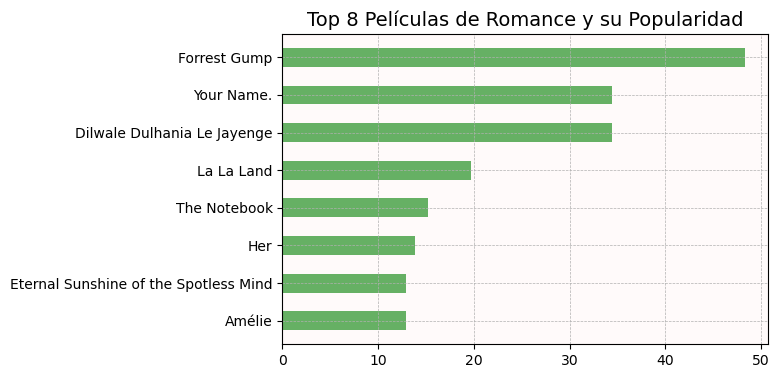

In [16]:
plot_popularity("Romance")

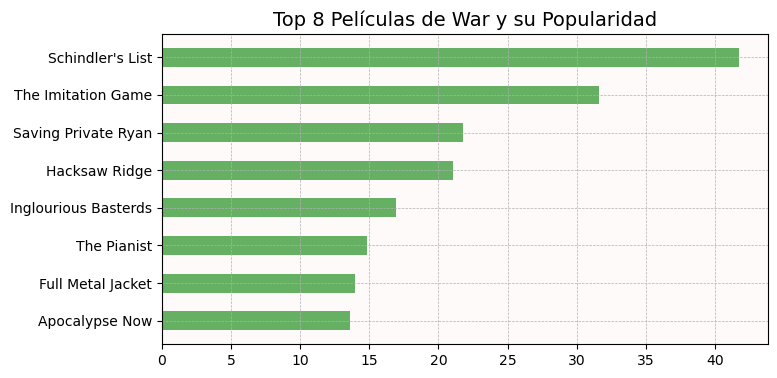

In [17]:
plot_popularity("War")

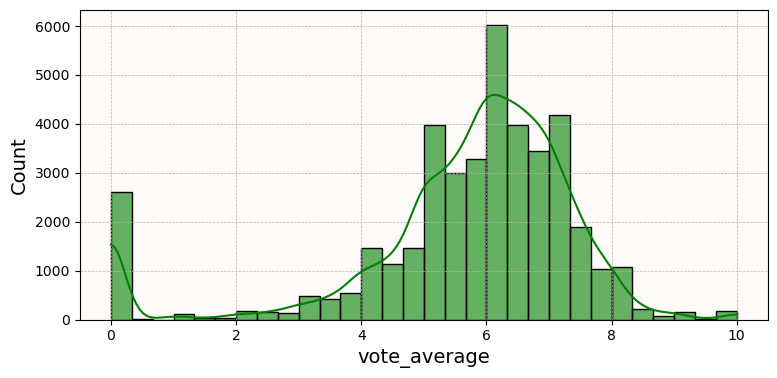

In [18]:
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(df["vote_average"], kde=True, color="green", alpha=0.6, bins=30)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.gca().set_facecolor("snow")
save_fig("vote_average_distribution")

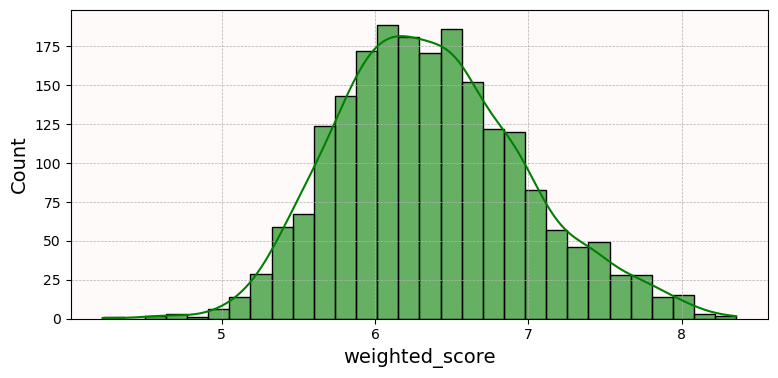

In [19]:
plt.figure(figsize=(8, 4))
sns.histplot(m_movies["weighted_score"], kde=True, color="green", alpha=0.6, bins=30)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.gca().set_facecolor("snow")
save_fig("weighted_score_distribution")

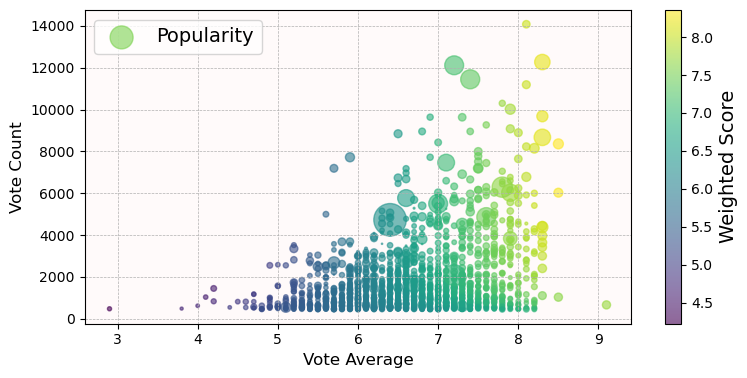

In [20]:
plt.figure(figsize=(8, 4))
plt.scatter(m_movies["vote_average"], m_movies["vote_count"], alpha=0.6, 
            s=m_movies["popularity"], c=m_movies["weighted_score"], cmap="viridis", label="Popularity")
plt.colorbar(label="Weighted Score")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.xlabel("Vote Average", fontsize=12)
plt.ylabel("Vote Count", fontsize=12)
plt.gca().set_facecolor("snow")
plt.legend(loc="upper left")
save_fig("vote_average_and_count_distribution_top95")